# Importazione librerie

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Lettura dati Bitcoin

In [158]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [159]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [160]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
# data_inizio = '2021-05-01'
# data_fine = '2021-07-31'

# Periodo personale
data_inizio = '2020-02-29'
data_fine = '2020-09-01'

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2020-02-29,7798.025879
1,2020-03-01,7748.164551
2,2020-03-02,7959.358398
3,2020-03-03,7862.485352
4,2020-03-04,7861.055176
...,...,...
181,2020-08-28,9695.468750
182,2020-08-29,9664.351562
183,2020-08-30,9824.922852
184,2020-08-31,9785.023438


In [161]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

# Strategia

In [162]:
def strategia_value_averaging_obiettivo_variabile(
    dati, liquidita_iniziale, bitcoin_iniziali, obiettivo_0, timeframe,
    acquisto_attivo, vendita_attiva,
    acquisto_rispetto_precedente, vendita_rispetto_precedente
):
    # Inizializzazione delle variabili
    liquidita = liquidita_iniziale
    bitcoin = bitcoin_iniziali
    obiettivo = obiettivo_0
    ultimo_prezzo_ribilanciamento = dati.iloc[0]["Price"]
    penultimo_prezzo_ribilanciamento = None
    prezzo_riferimento = ultimo_prezzo_ribilanciamento

    # Lista per tracciare tutte le transazioni giornaliere
    transazioni = []

    # Gestione della prima transazione (giorno 0)
    prima_riga = dati.iloc[0]
    timestamp = prima_riga["Timestamp"]
    prezzo = prima_riga["Price"]
    azione = 'Acquisto'

    # Calcolo dell'acquisto iniziale necessario per raggiungere l'obiettivo_0
    controvalore_bitcoin = bitcoin * prezzo
    liquidita_necessaria = obiettivo - controvalore_bitcoin
    if liquidita_necessaria > 0 and acquisto_attivo and liquidita >= liquidita_necessaria:
        acquisto_btc = liquidita_necessaria / prezzo
        liquidita -= liquidita_necessaria
        bitcoin += acquisto_btc
        liquidita_transazione = -liquidita_necessaria
        bitcoin_transazione = acquisto_btc
    else:
        acquisto_btc = 0
        liquidita_transazione = '-'
        bitcoin_transazione = '-'
        azione = '-'

    # Salvataggio della transazione del giorno 0
    transazioni.append({
        "timestamp": timestamp,
        "prezzo": prezzo,
        "obiettivo": obiettivo,
        "azione": azione,
        "liquidita_transazione": liquidita_transazione,
        "bitcoin_transazione": bitcoin_transazione,
        "fattore_di_variazione": '-',
        "fattore_di_variazione_cumulativa": '-',
        "liquidità": liquidita,
        "bitcoin": bitcoin,
        "controvalore_bitcoin": bitcoin * prezzo,
        "valore_totale_portafoglio": liquidita + bitcoin * prezzo
    })

    # Ciclo dal giorno 1 in poi
    for i, row in dati.iloc[1:].iterrows():
        timestamp = row["Timestamp"]
        prezzo = row["Price"]
        azione = '-'
        # fattore_variabile_cumulativo = fattore_variabile
        liquidita_transazione = '-'
        bitcoin_transazione = '-'

        # Controllo se è un giorno di ribilanciamento
        if i % timeframe == 0:
            if i // timeframe >= 2:
                penultimo_prezzo_ribilanciamento = dati.iloc[i-2]['Price']
                if (prezzo - ultimo_prezzo_ribilanciamento) * (ultimo_prezzo_ribilanciamento - penultimo_prezzo_ribilanciamento) < 0:
                    prezzo_riferimento = ultimo_prezzo_ribilanciamento
                # print(i, prezzo_riferimento)

            # Determina fattore cumulativo rispetto alla discesa o salita
            if prezzo < ultimo_prezzo_ribilanciamento:
                fattore_variabile = ultimo_prezzo_ribilanciamento / prezzo
                fattore_variabile_cumulativo = prezzo_riferimento / prezzo
                if not acquisto_rispetto_precedente:
                    fattore_variabile_riferimento = fattore_variabile_cumulativo
                else:
                    fattore_variabile_riferimento = fattore_variabile

                obiettivo *= fattore_variabile_riferimento

            elif prezzo > ultimo_prezzo_ribilanciamento:
                fattore_variabile = prezzo / ultimo_prezzo_ribilanciamento
                fattore_variabile_cumulativo = prezzo / prezzo_riferimento
                if not vendita_rispetto_precedente:
                    fattore_variabile_riferimento = fattore_variabile_cumulativo
                else:
                    fattore_variabile_riferimento = fattore_variabile

                obiettivo /= fattore_variabile_riferimento

            controvalore_bitcoin = bitcoin * prezzo
            liquidita_necessaria = obiettivo - controvalore_bitcoin

            # Se è il momento di acquistare
            if liquidita_necessaria > 0 and acquisto_attivo and liquidita >= liquidita_necessaria:
                acquisto_btc = liquidita_necessaria / prezzo
                liquidita -= liquidita_necessaria
                bitcoin += acquisto_btc
                azione = 'Acquisto' if acquisto_btc > 0 else '-'
                liquidita_transazione = -liquidita_necessaria
                bitcoin_transazione = acquisto_btc

            # Se è il momento di vendere
            elif liquidita_necessaria < 0 and vendita_attiva and -liquidita_necessaria / prezzo <= bitcoin:
                vendita_btc = -liquidita_necessaria / prezzo
                liquidita += -liquidita_necessaria
                bitcoin -= vendita_btc
                azione = 'Vendita' if vendita_btc > 0 else '-'
                liquidita_transazione = -liquidita_necessaria
                bitcoin_transazione = -vendita_btc

            ultimo_prezzo_ribilanciamento = prezzo

        # Calcolo del valore totale del portafoglio
        valore_totale_portafoglio = liquidita + bitcoin * prezzo

        # Salvataggio della transazione del giorno
        transazioni.append({
            "timestamp": timestamp,
            "prezzo": prezzo,
            "obiettivo": obiettivo,
            "azione": azione,
            "liquidita_transazione": liquidita_transazione,
            "bitcoin_transazione": bitcoin_transazione,
            "fattore_di_variazione": fattore_variabile,
            "fattore_di_variazione_cumulativa": fattore_variabile_riferimento,
            "liquidità": liquidita,
            "bitcoin": bitcoin,
            "controvalore_bitcoin": bitcoin * prezzo,
            "valore_totale_portafoglio": valore_totale_portafoglio
        })

    # Creazione del DataFrame finale
    df_transazioni = pd.DataFrame(transazioni)
    return df_transazioni

In [163]:
liquidita_iniziale = 1000
bitcoin_iniziali = 0
obiettivo_0 = 50
timeframe = 1
acquisto_attivo = True
vendita_attiva = True
acquisto_rispetto_precedente = False
vendita_rispetto_precedente = False

df_transazioni = strategia_value_averaging_obiettivo_variabile(dati, liquidita_iniziale, bitcoin_iniziali, obiettivo_0, timeframe, acquisto_attivo, vendita_attiva, acquisto_rispetto_precedente, vendita_rispetto_precedente)
df_transazioni

,timestamp,prezzo,obiettivo,azione,liquidita_transazione,bitcoin_transazione,fattore_di_variazione,fattore_di_variazione_cumulativa,liquidità,bitcoin,controvalore_bitcoin,valore_totale_portafoglio
0,2020-02-29,7798.025879,50.000000,Acquisto,-50.000000,0.006412,-,-,950.000000,0.006412,50.000000,1000.000000
1,2020-03-01,7748.164551,50.321762,Acquisto,-0.641467,0.000083,1.006435,1.006435,949.358533,0.006495,50.321762,999.680295
2,2020-03-02,7959.358398,48.986523,Vendita,2.706873,-0.000340,1.027257,1.027257,952.065406,0.006155,48.986523,1001.051929
3,2020-03-03,7862.485352,49.590082,Acquisto,-1.199772,0.000153,1.012321,1.012321,950.865634,0.006307,49.590082,1000.455716
4,2020-03-04,7861.055176,50.210211,Acquisto,-0.629149,0.000080,1.000182,1.012505,950.236485,0.006387,50.210211,1000.446696
...,...,...,...,...,...,...,...,...,...,...,...,...
181,2020-08-28,9695.468750,18.857093,Vendita,0.452970,-0.000047,1.011939,1.011939,1010.275264,0.001945,18.857093,1029.132357
182,2020-08-29,9664.351562,18.917809,Acquisto,-0.121237,0.000013,1.00322,1.00322,1010.154027,0.001957,18.917809,1029.071836
183,2020-08-30,9824.922852,18.608631,Vendita,0.623494,-0.000063,1.016615,1.016615,1010.777521,0.001894,18.608631,1029.386152
184,2020-08-31,9785.023438,18.684509,Acquisto,-0.151449,0.000015,1.004078,1.004078,1010.626072,0.001910,18.684509,1029.310581


In [165]:
def plot_transazioni(df_transazioni, colonne):
    """
    Plotta le colonne specificate nel DataFrame df_transazioni.
    
    Args:
    - df_transazioni: DataFrame contenente le transazioni con una colonna Timestamp.
    - colonne: Lista di nomi delle colonne da plottare.
    """
    plt.figure(figsize=(12, 6))
    
    # Converte Timestamp in formato datetime se non lo è già
    if not pd.api.types.is_datetime64_any_dtype(df_transazioni["timestamp"]):
        df_transazioni["timestamp"] = pd.to_datetime(df_transazioni["timestamp"])
    
    # Plotta ogni colonna nell'elenco
    for colonna in colonne:
        if colonna in df_transazioni.columns:
            plt.plot(df_transazioni["timestamp"], df_transazioni[colonna], label=colonna)
        else:
            print(f"Colonna '{colonna}' non trovata nel DataFrame")
    
    # Configurazione del grafico
    plt.xlabel("Timestamp")
    plt.ylabel("€")
    plt.title("Andamento delle colonne selezionate nel tempo")
    plt.legend()
    plt.grid()
    plt.show()

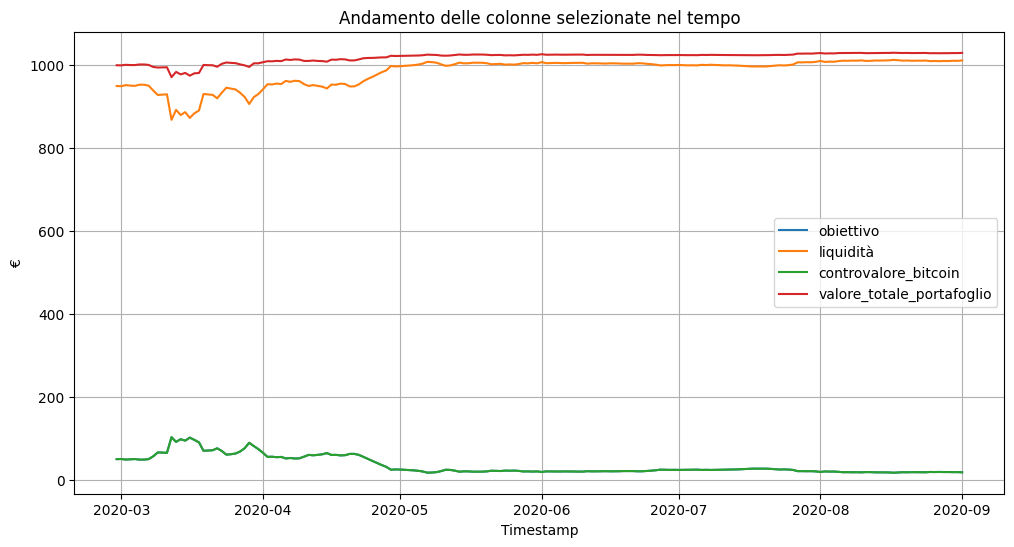

In [166]:
plot_transazioni(df_transazioni, ["obiettivo", "liquidità", "controvalore_bitcoin", "valore_totale_portafoglio"])

In [167]:
# Filtraggio delle transazioni per Acquisti e Vendite
acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']
vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']

# Calcolo delle dimensioni dei punti in base alla liquidità transatta in ogni operazione
max_acquisto = acquisti['liquidita_transazione'].abs().max()
max_vendita = vendite['liquidita_transazione'].abs().max()

def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if pd.notna(quantita) and max_quantita != 0 else None

# Dimensioni dei punti per acquisti e vendite
dimensioni_acquisti = acquisti['liquidita_transazione'].abs().apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['liquidita_transazione'].abs().apply(lambda x: calcola_dimensione(x, max_vendita))

# Funzione per formattare i valori
def safe_format(value, precision=2):
    return f"{value:.{precision}f}" if pd.notna(value) else "None"

# Creazione del grafico dei prezzi con le transazioni
fig = go.Figure()

# Linea dell'andamento dei prezzi
fig.add_trace(go.Scatter(
    x=df_transazioni['timestamp'], 
    y=df_transazioni['prezzo'],
    mode='lines',
    name='Prezzi',
    line=dict(color='blue', width=2),
    text=[
        f"Timestamp: {data}<br>Prezzo: {safe_format(p)} €<br>Fattore di variazione: {fv or 'None'}<br>Fattore di variazione cumulativa: {fvc or 'None'}<br>Obiettivo: {safe_format(obj)} €<br>Valore totale portafoglio: {safe_format(val)} €"
        for data, p, fv, fvc, obj, val in zip(
            df_transazioni['timestamp'], 
            df_transazioni['prezzo'], 
            df_transazioni['fattore_di_variazione'], 
            df_transazioni['fattore_di_variazione_cumulativa'], 
            df_transazioni['obiettivo'], 
            df_transazioni['valore_totale_portafoglio']
        )
    ],
    hoverinfo='text'
))

# Scatter plot per gli acquisti
if len(acquisti) > 0:
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'], 
        y=acquisti['prezzo'],
        mode='markers', 
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=[
            f"Timestamp: {data}<br>Prezzo: {safe_format(p)} €<br>Liquidità spesa: {safe_format(euro)} €<br>Bitcoin acquistati: {btc or 'None'}"
            for data, p, euro, btc in zip(
                acquisti['timestamp'], 
                acquisti['prezzo'], 
                acquisti['liquidita_transazione'], 
                acquisti['bitcoin_transazione']
            )
        ],
        hoverinfo='text'
    ))

# Scatter plot per le vendite
if len(vendite) > 0:
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'], 
        y=vendite['prezzo'],
        mode='markers', 
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=[
            f"Timestamp: {data}<br>Prezzo: {safe_format(p)} €<br>Liquidità guadagnata: {safe_format(euro)} €<br>Bitcoin venduti: {btc or 'None'}"
            for data, p, euro, btc in zip(
                vendite['timestamp'], 
                vendite['prezzo'], 
                vendite['liquidita_transazione'], 
                vendite['bitcoin_transazione']
            )
        ],
        hoverinfo='text'
    ))

# Configurazione del layout con range slider sull'asse X
fig.update_layout(
    title='Andamento dei prezzi e transazioni',
    xaxis_title='Data',
    yaxis_title='Prezzo (€)',
    hovermode='closest',
    template='plotly_white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    width=1000,
    height=7 / 10 * 1600,
    
    # Aggiunta del range slider
    xaxis=dict(
        rangeslider=dict(visible=True),  # Abilita il range slider
        type="date"  # Imposta l'asse x come asse temporale
    )
)

# Mostra il grafico
fig.show()